In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import concurrent.futures
from itertools import repeat

In [2]:
# load data
df_edges = pd.read_csv("../data/musae_git_edges.csv")
df_nodes = pd.read_csv("../data/musae_git_target.csv")

In [3]:
df_nodes.head()

,id,name,ml_target
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1


In [4]:
df_edges.head()

,id_1,id_2
0,0,23977
1,1,34526
2,1,2370
3,1,14683
4,1,29982


In [5]:
# create graph
G = nx.Graph()

# Add nodes to the graph
for index, row in df_nodes.iterrows():
    G.add_node(row['id'], status=row['ml_target'])

# Add edges to the graph
for index, row in df_edges.iterrows():
    G.add_edge(row['id_1'], row['id_2'])

Skip this line and maybe load pickle file. Computation takes about 32 mins (parallel processing) on MacBookPro 2017 13"

In [6]:
from helper import run_simulation_wrapper

if __name__ == '__main__':
    result_groups = []
    parameters = [
        (G.copy(), 0.3, 0.2, 50000),
        (G.copy(), 0.5, 0.2, 50000),
        (G.copy(), 0.5, 0.3, 50000),
        (G.copy(), 0.7, 0.3, 50000),
        (G.copy(), 0.7, 0.5, 50000),
        (G.copy(), 1.0, 0.5, 50000),
    ]

    with concurrent.futures.ProcessPoolExecutor() as executor:
        future_results = [executor.submit(run_simulation_wrapper, args) for args in parameters]

        for future in concurrent.futures.as_completed(future_results):
            result = future.result()
            result_groups.append(result)

In [7]:
file_path = 'result_groups-parallel.pickle'
with open(file_path, "wb") as file:
    pickle.dump(result_groups, file)

# with open(file_path, "rb") as file:
#     result_groups = pickle.load(file)

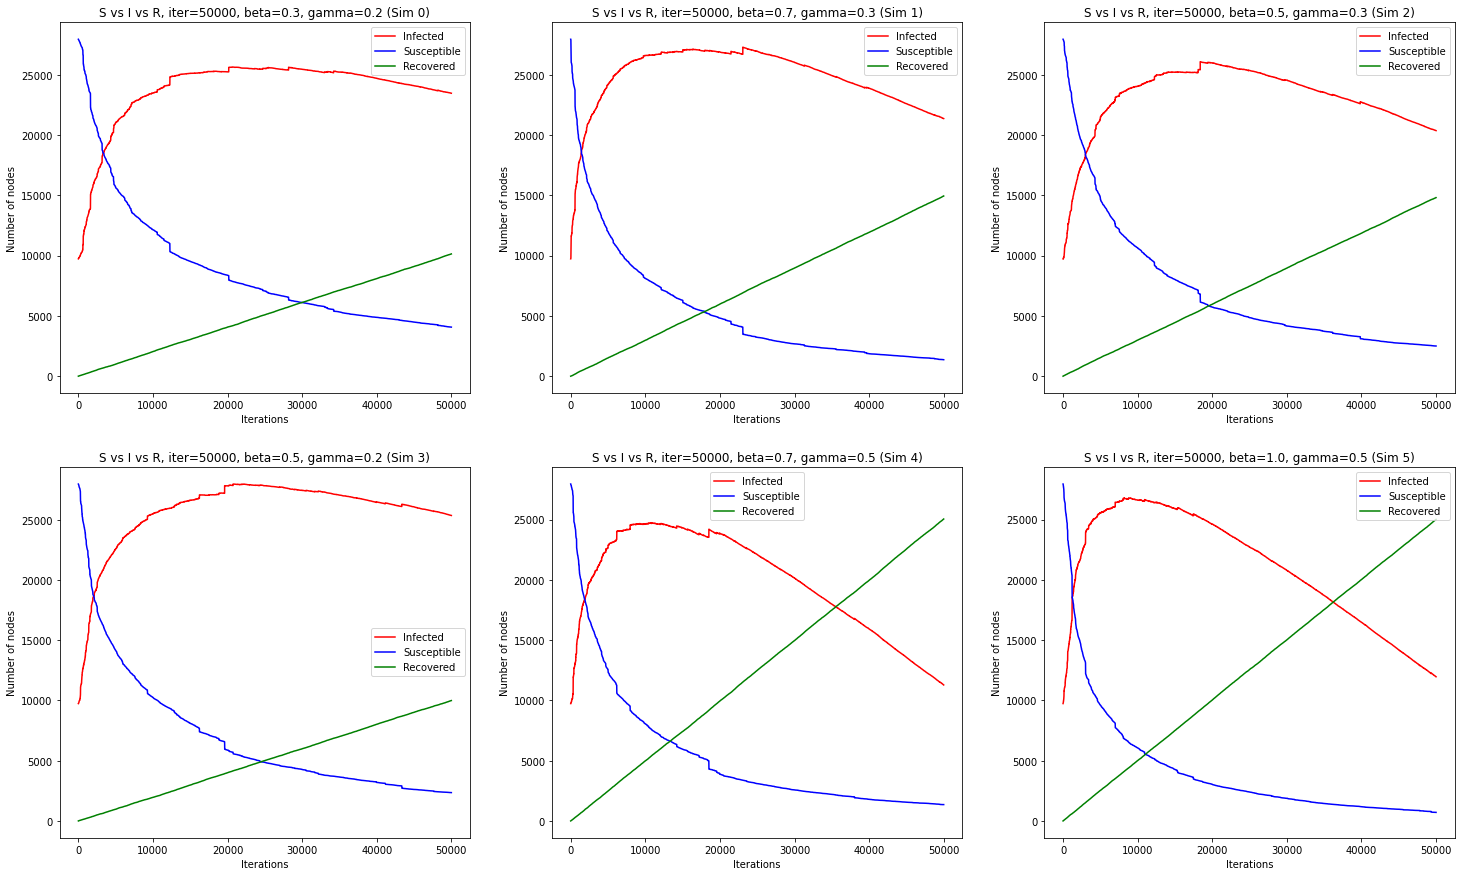

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
axs=axs.flatten()
i = 0

for ax, results in zip(axs, result_groups):
    x_val = range(results[4])
    title = f"S vs I vs R, iter={results[4]}, beta={results[5]}, gamma={results[6]} (Sim {i})"

    ax.plot(x_val, results[1], color='red', label='Infected')
    ax.plot(x_val, results[2], color='blue', label='Susceptible')
    ax.plot(x_val, results[3], color='green', label='Recovered')
    ax.legend()

    ax.set_xlabel("Iterations")
    ax.set_ylabel("Number of nodes")
    
    ax.set_title(title)
    i+=1

fig.savefig(f"plots/simple-contagion.jpg", bbox_inches='tight', dpi=300)
fig.savefig(f"plots/simple-contagion-smallsize.jpg", bbox_inches='tight', dpi=150)
plt.show()   


In [9]:
df_list = []
for results in result_groups:
    # Get the node attributes as a dictionary
    node_dict = nx.get_node_attributes(results[0], 'status')
    influence_dict = nx.get_node_attributes(results[0], 'influence')
    processed_dict = nx.get_node_attributes(results[0], 'processed')

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame({
        'id': node_dict.keys(),
        'status': node_dict.values(),
        'influence': influence_dict.values(),
        'processed': processed_dict.values()
    })
    df_list.append(df)

In [10]:
# get the nodes from the graph with the most connections
sorted_influential = dict(sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True))
top_20_infl = dict(list(sorted_influential.items())[:20])
top_20_infl

{31890: 0.25088198625958247,
 27803: 0.18793601952306427,
 35773: 0.08817210005570439,
 19222: 0.07846361972466113,
 13638: 0.06546592747818245,
 36652: 0.062150189660203185,
 18163: 0.05103583649433672,
 9051: 0.04766704687126979,
 35008: 0.0416721928963633,
 10001: 0.041592615188731794,
 36628: 0.03997453513355792,
 7027: 0.039390965277593566,
 19253: 0.03724236717154301,
 2078: 0.03628743467996499,
 33671: 0.03573039072654447,
 5629: 0.03490808774768561,
 73: 0.03360831852303774,
 3712: 0.033528740815406244,
 11051: 0.03289211915435423,
 30002: 0.027984827183744926}

In [11]:
# show the nodes that have infected the most nodes and check if these also coincide with 
# the nodes with the most connections

top_ids = []
for df in df_list:
    top_infl = df.sort_values('influence', ascending=False).head()
    print(top_infl)
    print(" ")

    common_ids = set(top_infl['id'].tolist()).intersection(set(top_20_infl.keys()))
    top_ids += list(common_ids)
    print(f"Common IDs from top influential nodes and most connected nodes: {common_ids}")
    print(" ")

          id  status  influence  processed
27803  27803       1       2008          1
31890  31890       2       1407          1
19222  19222       1        903          1
13638  13638       2        335          1
3712    3712       2        329          1
 
Common IDs from top influential nodes and most connected nodes: {3712, 13638, 31890, 19222, 27803}
 
          id  status  influence  processed
13638  13638       1       1810          1
19222  19222       2       1433          1
31890  31890       2        590          1
30002  30002       2        547          1
36628  36628       1        281          1
 
Common IDs from top influential nodes and most connected nodes: {13638, 31890, 30002, 36628, 19222}
 
          id  status  influence  processed
31890  31890       2        832          1
19222  19222       2        568          1
10595  10595       2        447          1
33029  33029       2        363          1
23589  23589       2        338          1
 
Common IDs from t

In [12]:
# count the coinciding nodes and on how many simulations they appear as the most influential
counted_ids = dict(sorted(Counter(top_ids).items(), key=lambda x: x[1], reverse=True))
counted_ids

{31890: 5,
 19222: 4,
 13638: 3,
 27803: 2,
 35008: 2,
 36652: 2,
 35773: 2,
 3712: 1,
 30002: 1,
 36628: 1,
 73: 1,
 9051: 1,
 10001: 1}

In [13]:
# display their initial status
df_nodes_indexed = df_nodes.set_index("id")
df_nodes_indexed.loc[list(counted_ids.keys())]

,name,ml_target
id,,
31890,dalinhuang99,0
19222,Bunlong,0
13638,gabrielpconceicao,0
27803,nfultz,0
35008,mdo,0
36652,rfthusn,0
35773,addyosmani,0
3712,isaacs,0
30002,kauegimenes,0


In [14]:
# get the nodes from the graph with the least connections that are ML devs
sorted_disatvantage = dict(sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=False))
least_inf_ml = list(df_nodes_indexed.loc[list(sorted_disatvantage.keys())][df_nodes_indexed['ml_target'] == 1].head(n=20).index)
least_inf_ml

/var/folders/q2/wz31b41120l4chrx6_0zn1ym0000gn/T/ipykernel_2820/1228448069.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  least_inf_ml = list(df_nodes_indexed.loc[list(sorted_disatvantage.keys())][df_nodes_indexed['ml_target'] == 1].head(n=20).index)


[2,
 37,
 59,
 62,
 77,
 79,
 153,
 170,
 172,
 196,
 209,
 217,
 220,
 234,
 245,
 247,
 267,
 289,
 299,
 331]

In [15]:
# since simulations take to long to terminate, we consider the nodes who were visited at least once
# during the sumulation

bot_ids = []
for df in df_list:
    bot_infl = df[df['processed'] == 1].sort_values('influence', ascending=True).head()
    print(bot_infl)
    print(" ")

          id  status  influence  processed
18762  18762       1          0          1
23460  23460       2          0          1
23457  23457       1          0          1
23456  23456       2          0          1
23455  23455       2          0          1
 
          id  status  influence  processed
1          1       1          0          1
23441  23441       2          0          1
23440  23440       2          0          1
23438  23438       1          0          1
23434  23434       2          0          1
 
          id  status  influence  processed
2          2       2          0          1
23427  23427       1          0          1
23426  23426       1          0          1
23424  23424       1          0          1
23422  23422       1          0          1
 
          id  status  influence  processed
18774  18774       1          0          1
32474  32474       1          0          1
32475  32475       1          0          1
19715  19715       2          0          1
19714

In [16]:
# calculating reproduction rate (second infections)
for idx, df in enumerate(df_list):
    df_idx = df.set_index('id')
    second_infections = df_idx.loc[(df_nodes_indexed['ml_target'] == 0) & (df_idx['status'] !=0) & (df_idx['processed'] == 1)]
    infected_total = second_infections['influence'].sum()
    total_nodes = len(second_infections)
    average_infected = infected_total/total_nodes
    print(f"Reproduction rate for simulation {idx}: {average_infected}")

Reproduction rate for simulation 0: 1.1555352241537054
Reproduction rate for simulation 1: 1.1305287896592244
Reproduction rate for simulation 2: 1.0763075722092115
Reproduction rate for simulation 3: 1.1533204121187393
Reproduction rate for simulation 4: 1.0041311754684838
Reproduction rate for simulation 5: 1.0025930572982016
